# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [12]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [91]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()
        self.counting = 0

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        if(len(self.card_deck) < 15):
            deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
            deck = deck * 4
            random.shuffle(deck)
            self.card_deck = self.card_deck + deck
            self.counting = self.counting / 4
        

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [92]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [93]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
            deck.counting -=1
        elif(new_card < 7):
            deck.counting += 1
        elif(new_card > 9):
            deck.counting -= 1
        self.hands.append(new_card)


    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        random_v = random.randint(1, 100)
        if(random_v == 2 or random_v == 5 or random_v == 10):
            return self.random_action()
        else:
            if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
                return True     # Hit
            elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
                return self.random_action()
            else:
                return False    # Stick  


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [94]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부
        length = 0      # class list의 길이
        burst_high = 0
        maybe_small = 0


        episode = list()    # 에피소드
        if(dealer.show() == 10 and dealer.show() == 11):
            deck.counting -= 1
        else:
            deck.counting += 1

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            #state = (sums, bool(agent.usable_ace), dealer.show())

            if(deck.counting > 15 and sums > 15):
                burst_high = 4
            elif(deck.counting > 10 and sums > 15):
                burst_high = 3
            elif(deck.counting > 5 and sums > 15):
                burst_high = 2
            else:
                burst_high = 0
            
            if(deck.counting < 7 and sums < 14):
                hit_more = 0
            elif(deck.counting < 15 and sums < 14):
                hit_more = 1
            else:
                hit_more = 2
            state = (sums, bool(agent.usable_ace), burst_high, dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            #if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
            #    action =agent.random_action()
            #else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
            action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])
            length += 1
            
            for dealer_card in dealer.hands:
                if(dealer_card < 7):
                    deck.counting += 1
                elif(dealer_card > 9):
                    deck.counting -= 1
            

        return episode, length

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode, temp = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [95]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [96]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [97]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :38.486%
 -- 1000 Games WIN : 356 DRAW : 75 LOSS : 569
Total win rate : 38.486%
 -- TOTAL Games WIN : 356 DRAW : 75 LOSS : 569
========== Training : Episode  2000  ===========
Recent 1000 games win rate :39.629%
 -- 1000 Games WIN : 363 DRAW : 84 LOSS : 553
Total win rate : 39.055%
 -- TOTAL Games WIN : 719 DRAW : 159 LOSS : 1122
========== Training : Episode  3000  ===========
Recent 1000 games win rate :41.577%
 -- 1000 Games WIN : 385 DRAW : 74 LOSS : 541
Total win rate : 39.899%
 -- TOTAL Games WIN : 1104 DRAW : 233 LOSS : 1663
========== Training : Episode  4000  ===========
Recent 1000 games win rate :41.075%
 -- 1000 Games WIN : 382 DRAW : 70 LOSS : 548
Total win rate : 40.195%
 -- TOTAL Games WIN : 1486 DRAW : 303 LOSS : 2211
========== Training : Episode  5000  ===========
Recent 1000 games win rate :38.621%
 -- 1000 Games WIN : 353 DRAW : 86 LOSS : 561
Total win rate : 39.883%
 -- TOTAL Games WIN : 18

========== Training : Episode  45000  ===========
Recent 1000 games win rate :45.504%
 -- 1000 Games WIN : 415 DRAW : 88 LOSS : 497
Total win rate : 43.512%
 -- TOTAL Games WIN : 18048 DRAW : 3522 LOSS : 23430
========== Training : Episode  46000  ===========
Recent 1000 games win rate :45.415%
 -- 1000 Games WIN : 421 DRAW : 73 LOSS : 506
Total win rate : 43.554%
 -- TOTAL Games WIN : 18469 DRAW : 3595 LOSS : 23936
========== Training : Episode  47000  ===========
Recent 1000 games win rate :43.757%
 -- 1000 Games WIN : 403 DRAW : 79 LOSS : 518
Total win rate : 43.558%
 -- TOTAL Games WIN : 18872 DRAW : 3674 LOSS : 24454
========== Training : Episode  48000  ===========
Recent 1000 games win rate :46.544%
 -- 1000 Games WIN : 431 DRAW : 74 LOSS : 495
Total win rate : 43.621%
 -- TOTAL Games WIN : 19303 DRAW : 3748 LOSS : 24949
========== Training : Episode  49000  ===========
Recent 1000 games win rate :44.168%
 -- 1000 Games WIN : 409 DRAW : 74 LOSS : 517
Total win rate : 43.632%
 --

========== Training : Episode  88000  ===========
Recent 1000 games win rate :44.688%
 -- 1000 Games WIN : 408 DRAW : 87 LOSS : 505
Total win rate : 44.253%
 -- TOTAL Games WIN : 35851 DRAW : 6987 LOSS : 45162
========== Training : Episode  89000  ===========
Recent 1000 games win rate :44.013%
 -- 1000 Games WIN : 408 DRAW : 73 LOSS : 519
Total win rate : 44.251%
 -- TOTAL Games WIN : 36259 DRAW : 7060 LOSS : 45681
========== Training : Episode  90000  ===========
Recent 1000 games win rate :42.687%
 -- 1000 Games WIN : 394 DRAW : 77 LOSS : 529
Total win rate : 44.233%
 -- TOTAL Games WIN : 36653 DRAW : 7137 LOSS : 46210
========== Training : Episode  91000  ===========
Recent 1000 games win rate :47.599%
 -- 1000 Games WIN : 446 DRAW : 63 LOSS : 491
Total win rate : 44.271%
 -- TOTAL Games WIN : 37099 DRAW : 7200 LOSS : 46701
========== Training : Episode  92000  ===========
Recent 1000 games win rate :48.852%
 -- 1000 Games WIN : 447 DRAW : 85 LOSS : 468
Total win rate : 44.320%
 --

========== Training : Episode  133000  ===========
Recent 1000 games win rate :46.121%
 -- 1000 Games WIN : 428 DRAW : 72 LOSS : 500
Total win rate : 44.639%
 -- TOTAL Games WIN : 54623 DRAW : 10634 LOSS : 67743
========== Training : Episode  134000  ===========
Recent 1000 games win rate :44.432%
 -- 1000 Games WIN : 407 DRAW : 84 LOSS : 509
Total win rate : 44.637%
 -- TOTAL Games WIN : 55030 DRAW : 10718 LOSS : 68252
========== Training : Episode  135000  ===========
Recent 1000 games win rate :47.730%
 -- 1000 Games WIN : 431 DRAW : 97 LOSS : 472
Total win rate : 44.660%
 -- TOTAL Games WIN : 55461 DRAW : 10815 LOSS : 68724
========== Training : Episode  136000  ===========
Recent 1000 games win rate :45.943%
 -- 1000 Games WIN : 419 DRAW : 88 LOSS : 493
Total win rate : 44.669%
 -- TOTAL Games WIN : 55880 DRAW : 10903 LOSS : 69217
========== Training : Episode  137000  ===========
Recent 1000 games win rate :45.277%
 -- 1000 Games WIN : 417 DRAW : 79 LOSS : 504
Total win rate : 44

========== Training : Episode  176000  ===========
Recent 1000 games win rate :47.201%
 -- 1000 Games WIN : 430 DRAW : 89 LOSS : 481
Total win rate : 44.999%
 -- TOTAL Games WIN : 72764 DRAW : 14297 LOSS : 88939
========== Training : Episode  177000  ===========
Recent 1000 games win rate :46.595%
 -- 1000 Games WIN : 431 DRAW : 75 LOSS : 494
Total win rate : 45.008%
 -- TOTAL Games WIN : 73195 DRAW : 14372 LOSS : 89433
========== Training : Episode  178000  ===========
Recent 1000 games win rate :45.969%
 -- 1000 Games WIN : 422 DRAW : 82 LOSS : 496
Total win rate : 45.013%
 -- TOTAL Games WIN : 73617 DRAW : 14454 LOSS : 89929
========== Training : Episode  179000  ===========
Recent 1000 games win rate :45.228%
 -- 1000 Games WIN : 417 DRAW : 78 LOSS : 505
Total win rate : 45.014%
 -- TOTAL Games WIN : 74034 DRAW : 14532 LOSS : 90434
========== Training : Episode  180000  ===========
Recent 1000 games win rate :45.865%
 -- 1000 Games WIN : 416 DRAW : 93 LOSS : 491
Total win rate : 45

========== Training : Episode  221000  ===========
Recent 1000 games win rate :47.650%
 -- 1000 Games WIN : 436 DRAW : 85 LOSS : 479
Total win rate : 45.280%
 -- TOTAL Games WIN : 91864 DRAW : 18121 LOSS : 111015
========== Training : Episode  222000  ===========
Recent 1000 games win rate :47.534%
 -- 1000 Games WIN : 424 DRAW : 108 LOSS : 468
Total win rate : 45.290%
 -- TOTAL Games WIN : 92288 DRAW : 18229 LOSS : 111483
========== Training : Episode  223000  ===========
Recent 1000 games win rate :45.585%
 -- 1000 Games WIN : 413 DRAW : 94 LOSS : 493
Total win rate : 45.291%
 -- TOTAL Games WIN : 92701 DRAW : 18323 LOSS : 111976
========== Training : Episode  224000  ===========
Recent 1000 games win rate :46.820%
 -- 1000 Games WIN : 427 DRAW : 88 LOSS : 485
Total win rate : 45.298%
 -- TOTAL Games WIN : 93128 DRAW : 18411 LOSS : 112461
========== Training : Episode  225000  ===========
Recent 1000 games win rate :47.960%
 -- 1000 Games WIN : 435 DRAW : 93 LOSS : 472
Total win rate

========== Training : Episode  271000  ===========
Recent 1000 games win rate :47.052%
 -- 1000 Games WIN : 431 DRAW : 84 LOSS : 485
Total win rate : 45.516%
 -- TOTAL Games WIN : 113101 DRAW : 22514 LOSS : 135385
========== Training : Episode  272000  ===========
Recent 1000 games win rate :44.420%
 -- 1000 Games WIN : 406 DRAW : 86 LOSS : 508
Total win rate : 45.512%
 -- TOTAL Games WIN : 113507 DRAW : 22600 LOSS : 135893
========== Training : Episode  273000  ===========
Recent 1000 games win rate :43.568%
 -- 1000 Games WIN : 403 DRAW : 75 LOSS : 522
Total win rate : 45.505%
 -- TOTAL Games WIN : 113910 DRAW : 22675 LOSS : 136415
========== Training : Episode  274000  ===========
Recent 1000 games win rate :45.394%
 -- 1000 Games WIN : 409 DRAW : 99 LOSS : 492
Total win rate : 45.504%
 -- TOTAL Games WIN : 114319 DRAW : 22774 LOSS : 136907
========== Training : Episode  275000  ===========
Recent 1000 games win rate :45.820%
 -- 1000 Games WIN : 422 DRAW : 79 LOSS : 499
Total win r

 -- TOTAL Games WIN : 129123 DRAW : 25798 LOSS : 154079
========== Training : Episode  310000  ===========
Recent 1000 games win rate :47.697%
 -- 1000 Games WIN : 435 DRAW : 88 LOSS : 477
Total win rate : 45.601%
 -- TOTAL Games WIN : 129558 DRAW : 25886 LOSS : 154556
========== Training : Episode  311000  ===========
Recent 1000 games win rate :48.746%
 -- 1000 Games WIN : 447 DRAW : 83 LOSS : 470
Total win rate : 45.611%
 -- TOTAL Games WIN : 130005 DRAW : 25969 LOSS : 155026
========== Training : Episode  312000  ===========
Recent 1000 games win rate :47.677%
 -- 1000 Games WIN : 431 DRAW : 96 LOSS : 473
Total win rate : 45.617%
 -- TOTAL Games WIN : 130436 DRAW : 26065 LOSS : 155499
========== Training : Episode  313000  ===========
Recent 1000 games win rate :48.031%
 -- 1000 Games WIN : 439 DRAW : 86 LOSS : 475
Total win rate : 45.625%
 -- TOTAL Games WIN : 130875 DRAW : 26151 LOSS : 155974
========== Training : Episode  314000  ===========
Recent 1000 games win rate :44.614%
 

========== Training : Episode  352000  ===========
Recent 1000 games win rate :45.775%
 -- 1000 Games WIN : 428 DRAW : 65 LOSS : 507
Total win rate : 45.701%
 -- TOTAL Games WIN : 147360 DRAW : 29558 LOSS : 175082
========== Training : Episode  353000  ===========
Recent 1000 games win rate :46.844%
 -- 1000 Games WIN : 423 DRAW : 97 LOSS : 480
Total win rate : 45.704%
 -- TOTAL Games WIN : 147783 DRAW : 29655 LOSS : 175562
========== Training : Episode  354000  ===========
Recent 1000 games win rate :45.815%
 -- 1000 Games WIN : 416 DRAW : 92 LOSS : 492
Total win rate : 45.705%
 -- TOTAL Games WIN : 148199 DRAW : 29747 LOSS : 176054
========== Training : Episode  355000  ===========
Recent 1000 games win rate :45.606%
 -- 1000 Games WIN : 410 DRAW : 101 LOSS : 489
Total win rate : 45.704%
 -- TOTAL Games WIN : 148609 DRAW : 29848 LOSS : 176543
========== Training : Episode  356000  ===========
Recent 1000 games win rate :49.239%
 -- 1000 Games WIN : 453 DRAW : 80 LOSS : 467
Total win 

========== Training : Episode  396000  ===========
Recent 1000 games win rate :49.055%
 -- 1000 Games WIN : 441 DRAW : 101 LOSS : 458
Total win rate : 45.850%
 -- TOTAL Games WIN : 166206 DRAW : 33501 LOSS : 196293
========== Training : Episode  397000  ===========
Recent 1000 games win rate :45.761%
 -- 1000 Games WIN : 421 DRAW : 80 LOSS : 499
Total win rate : 45.850%
 -- TOTAL Games WIN : 166627 DRAW : 33581 LOSS : 196792
========== Training : Episode  398000  ===========
Recent 1000 games win rate :44.286%
 -- 1000 Games WIN : 403 DRAW : 90 LOSS : 507
Total win rate : 45.846%
 -- TOTAL Games WIN : 167030 DRAW : 33671 LOSS : 197299
========== Training : Episode  399000  ===========
Recent 1000 games win rate :48.448%
 -- 1000 Games WIN : 437 DRAW : 98 LOSS : 465
Total win rate : 45.852%
 -- TOTAL Games WIN : 167467 DRAW : 33769 LOSS : 197764
========== Training : Episode  400000  ===========
Recent 1000 games win rate :45.022%
 -- 1000 Games WIN : 407 DRAW : 96 LOSS : 497
Total win 

========== Training : Episode  440000  ===========
Recent 1000 games win rate :44.227%
 -- 1000 Games WIN : 406 DRAW : 82 LOSS : 512
Total win rate : 45.960%
 -- TOTAL Games WIN : 185082 DRAW : 37301 LOSS : 217617
========== Training : Episode  441000  ===========
Recent 1000 games win rate :48.602%
 -- 1000 Games WIN : 452 DRAW : 70 LOSS : 478
Total win rate : 45.966%
 -- TOTAL Games WIN : 185534 DRAW : 37371 LOSS : 218095
========== Training : Episode  442000  ===========
Recent 1000 games win rate :43.536%
 -- 1000 Games WIN : 394 DRAW : 95 LOSS : 511
Total win rate : 45.961%
 -- TOTAL Games WIN : 185928 DRAW : 37466 LOSS : 218606
========== Training : Episode  443000  ===========
Recent 1000 games win rate :45.806%
 -- 1000 Games WIN : 426 DRAW : 70 LOSS : 504
Total win rate : 45.961%
 -- TOTAL Games WIN : 186354 DRAW : 37536 LOSS : 219110
========== Training : Episode  444000  ===========
Recent 1000 games win rate :46.865%
 -- 1000 Games WIN : 426 DRAW : 91 LOSS : 483
Total win r

========== Training : Episode  481000  ===========
Recent 1000 games win rate :46.748%
 -- 1000 Games WIN : 424 DRAW : 93 LOSS : 483
Total win rate : 46.015%
 -- TOTAL Games WIN : 202547 DRAW : 40826 LOSS : 237627
========== Training : Episode  482000  ===========
Recent 1000 games win rate :46.491%
 -- 1000 Games WIN : 424 DRAW : 88 LOSS : 488
Total win rate : 46.016%
 -- TOTAL Games WIN : 202971 DRAW : 40914 LOSS : 238115
========== Training : Episode  483000  ===========
Recent 1000 games win rate :47.162%
 -- 1000 Games WIN : 432 DRAW : 84 LOSS : 484
Total win rate : 46.019%
 -- TOTAL Games WIN : 203403 DRAW : 40998 LOSS : 238599
========== Training : Episode  484000  ===========
Recent 1000 games win rate :44.204%
 -- 1000 Games WIN : 408 DRAW : 77 LOSS : 515
Total win rate : 46.015%
 -- TOTAL Games WIN : 203811 DRAW : 41075 LOSS : 239114
========== Training : Episode  485000  ===========
Recent 1000 games win rate :48.534%
 -- 1000 Games WIN : 447 DRAW : 79 LOSS : 474
Total win r

========== Training : Episode  529000  ===========
Recent 1000 games win rate :46.776%
 -- 1000 Games WIN : 428 DRAW : 85 LOSS : 487
Total win rate : 46.118%
 -- TOTAL Games WIN : 223200 DRAW : 45029 LOSS : 260771
========== Training : Episode  530000  ===========
Recent 1000 games win rate :47.225%
 -- 1000 Games WIN : 434 DRAW : 81 LOSS : 485
Total win rate : 46.121%
 -- TOTAL Games WIN : 223634 DRAW : 45110 LOSS : 261256
========== Training : Episode  531000  ===========
Recent 1000 games win rate :44.907%
 -- 1000 Games WIN : 410 DRAW : 87 LOSS : 503
Total win rate : 46.118%
 -- TOTAL Games WIN : 224044 DRAW : 45197 LOSS : 261759
========== Training : Episode  532000  ===========
Recent 1000 games win rate :47.105%
 -- 1000 Games WIN : 423 DRAW : 102 LOSS : 475
Total win rate : 46.120%
 -- TOTAL Games WIN : 224467 DRAW : 45299 LOSS : 262234
========== Training : Episode  533000  ===========
Recent 1000 games win rate :47.807%
 -- 1000 Games WIN : 436 DRAW : 88 LOSS : 476
Total win 

 -- TOTAL Games WIN : 242087 DRAW : 48926 LOSS : 281987
========== Training : Episode  574000  ===========
Recent 1000 games win rate :45.958%
 -- 1000 Games WIN : 415 DRAW : 97 LOSS : 488
Total win rate : 46.193%
 -- TOTAL Games WIN : 242502 DRAW : 49023 LOSS : 282475
========== Training : Episode  575000  ===========
Recent 1000 games win rate :44.913%
 -- 1000 Games WIN : 415 DRAW : 76 LOSS : 509
Total win rate : 46.191%
 -- TOTAL Games WIN : 242917 DRAW : 49099 LOSS : 282984
========== Training : Episode  576000  ===========
Recent 1000 games win rate :46.171%
 -- 1000 Games WIN : 416 DRAW : 99 LOSS : 485
Total win rate : 46.191%
 -- TOTAL Games WIN : 243333 DRAW : 49198 LOSS : 283469
========== Training : Episode  577000  ===========
Recent 1000 games win rate :46.094%
 -- 1000 Games WIN : 413 DRAW : 104 LOSS : 483
Total win rate : 46.190%
 -- TOTAL Games WIN : 243746 DRAW : 49302 LOSS : 283952
========== Training : Episode  578000  ===========
Recent 1000 games win rate :48.075%


========== Training : Episode  616000  ===========
Recent 1000 games win rate :46.499%
 -- 1000 Games WIN : 425 DRAW : 86 LOSS : 489
Total win rate : 46.244%
 -- TOTAL Games WIN : 260450 DRAW : 52795 LOSS : 302755
========== Training : Episode  617000  ===========
Recent 1000 games win rate :46.341%
 -- 1000 Games WIN : 418 DRAW : 98 LOSS : 484
Total win rate : 46.244%
 -- TOTAL Games WIN : 260868 DRAW : 52893 LOSS : 303239
========== Training : Episode  618000  ===========
Recent 1000 games win rate :45.228%
 -- 1000 Games WIN : 417 DRAW : 78 LOSS : 505
Total win rate : 46.243%
 -- TOTAL Games WIN : 261285 DRAW : 52971 LOSS : 303744
========== Training : Episode  619000  ===========
Recent 1000 games win rate :44.745%
 -- 1000 Games WIN : 413 DRAW : 77 LOSS : 510
Total win rate : 46.240%
 -- TOTAL Games WIN : 261698 DRAW : 53048 LOSS : 304254
========== Training : Episode  620000  ===========
Recent 1000 games win rate :45.991%
 -- 1000 Games WIN : 413 DRAW : 102 LOSS : 485
Total win 

========== Training : Episode  661000  ===========
Recent 1000 games win rate :46.137%
 -- 1000 Games WIN : 418 DRAW : 94 LOSS : 488
Total win rate : 46.293%
 -- TOTAL Games WIN : 279714 DRAW : 56773 LOSS : 324513
========== Training : Episode  662000  ===========
Recent 1000 games win rate :50.503%
 -- 1000 Games WIN : 452 DRAW : 105 LOSS : 443
Total win rate : 46.299%
 -- TOTAL Games WIN : 280166 DRAW : 56878 LOSS : 324956
========== Training : Episode  663000  ===========
Recent 1000 games win rate :45.267%
 -- 1000 Games WIN : 416 DRAW : 81 LOSS : 503
Total win rate : 46.298%
 -- TOTAL Games WIN : 280582 DRAW : 56959 LOSS : 325459
========== Training : Episode  664000  ===========
Recent 1000 games win rate :46.748%
 -- 1000 Games WIN : 424 DRAW : 93 LOSS : 483
Total win rate : 46.298%
 -- TOTAL Games WIN : 281006 DRAW : 57052 LOSS : 325942
========== Training : Episode  665000  ===========
Recent 1000 games win rate :47.656%
 -- 1000 Games WIN : 427 DRAW : 104 LOSS : 469
Total win

========== Training : Episode  700000  ===========
Recent 1000 games win rate :46.499%
 -- 1000 Games WIN : 425 DRAW : 86 LOSS : 489
Total win rate : 46.326%
 -- TOTAL Games WIN : 296391 DRAW : 60211 LOSS : 343398
========== Training : Episode  701000  ===========
Recent 1000 games win rate :47.339%
 -- 1000 Games WIN : 427 DRAW : 98 LOSS : 475
Total win rate : 46.328%
 -- TOTAL Games WIN : 296818 DRAW : 60309 LOSS : 343873
========== Training : Episode  702000  ===========
Recent 1000 games win rate :47.085%
 -- 1000 Games WIN : 420 DRAW : 108 LOSS : 472
Total win rate : 46.329%
 -- TOTAL Games WIN : 297238 DRAW : 60417 LOSS : 344345
========== Training : Episode  703000  ===========
Recent 1000 games win rate :47.750%
 -- 1000 Games WIN : 435 DRAW : 89 LOSS : 476
Total win rate : 46.331%
 -- TOTAL Games WIN : 297673 DRAW : 60506 LOSS : 344821
========== Training : Episode  704000  ===========
Recent 1000 games win rate :46.444%
 -- 1000 Games WIN : 418 DRAW : 100 LOSS : 482
Total win

========== Training : Episode  747000  ===========
Recent 1000 games win rate :46.476%
 -- 1000 Games WIN : 422 DRAW : 92 LOSS : 486
Total win rate : 46.360%
 -- TOTAL Games WIN : 316444 DRAW : 64419 LOSS : 366137
========== Training : Episode  748000  ===========
Recent 1000 games win rate :49.390%
 -- 1000 Games WIN : 445 DRAW : 99 LOSS : 456
Total win rate : 46.364%
 -- TOTAL Games WIN : 316889 DRAW : 64518 LOSS : 366593
========== Training : Episode  749000  ===========
Recent 1000 games win rate :46.674%
 -- 1000 Games WIN : 421 DRAW : 98 LOSS : 481
Total win rate : 46.364%
 -- TOTAL Games WIN : 317310 DRAW : 64616 LOSS : 367074
========== Training : Episode  750000  ===========
Recent 1000 games win rate :46.637%
 -- 1000 Games WIN : 423 DRAW : 93 LOSS : 484
Total win rate : 46.365%
 -- TOTAL Games WIN : 317733 DRAW : 64709 LOSS : 367558
========== Training : Episode  751000  ===========
Recent 1000 games win rate :46.542%
 -- 1000 Games WIN : 424 DRAW : 89 LOSS : 487
Total win r

========== Training : Episode  792000  ===========
Recent 1000 games win rate :49.945%
 -- 1000 Games WIN : 453 DRAW : 93 LOSS : 454
Total win rate : 46.400%
 -- TOTAL Games WIN : 335716 DRAW : 68470 LOSS : 387814
========== Training : Episode  793000  ===========
Recent 1000 games win rate :47.960%
 -- 1000 Games WIN : 435 DRAW : 93 LOSS : 472
Total win rate : 46.402%
 -- TOTAL Games WIN : 336151 DRAW : 68563 LOSS : 388286
========== Training : Episode  794000  ===========
Recent 1000 games win rate :46.484%
 -- 1000 Games WIN : 423 DRAW : 90 LOSS : 487
Total win rate : 46.402%
 -- TOTAL Games WIN : 336574 DRAW : 68653 LOSS : 388773
========== Training : Episode  795000  ===========
Recent 1000 games win rate :47.603%
 -- 1000 Games WIN : 437 DRAW : 82 LOSS : 481
Total win rate : 46.403%
 -- TOTAL Games WIN : 337011 DRAW : 68735 LOSS : 389254
========== Training : Episode  796000  ===========
Recent 1000 games win rate :46.762%
 -- 1000 Games WIN : 426 DRAW : 89 LOSS : 485
Total win r

 -- TOTAL Games WIN : 355153 DRAW : 72401 LOSS : 409446
========== Training : Episode  838000  ===========
Recent 1000 games win rate :44.111%
 -- 1000 Games WIN : 397 DRAW : 100 LOSS : 503
Total win rate : 46.447%
 -- TOTAL Games WIN : 355550 DRAW : 72501 LOSS : 409949
========== Training : Episode  839000  ===========
Recent 1000 games win rate :47.784%
 -- 1000 Games WIN : 442 DRAW : 75 LOSS : 483
Total win rate : 46.448%
 -- TOTAL Games WIN : 355992 DRAW : 72576 LOSS : 410432
========== Training : Episode  840000  ===========
Recent 1000 games win rate :45.907%
 -- 1000 Games WIN : 415 DRAW : 96 LOSS : 489
Total win rate : 46.448%
 -- TOTAL Games WIN : 356407 DRAW : 72672 LOSS : 410921
========== Training : Episode  841000  ===========
Recent 1000 games win rate :47.437%
 -- 1000 Games WIN : 435 DRAW : 83 LOSS : 482
Total win rate : 46.449%
 -- TOTAL Games WIN : 356842 DRAW : 72755 LOSS : 411403
========== Training : Episode  842000  ===========
Recent 1000 games win rate :49.560%


========== Training : Episode  886000  ===========
Recent 1000 games win rate :47.588%
 -- 1000 Games WIN : 434 DRAW : 88 LOSS : 478
Total win rate : 46.480%
 -- TOTAL Games WIN : 376152 DRAW : 76724 LOSS : 433124
========== Training : Episode  887000  ===========
Recent 1000 games win rate :46.586%
 -- 1000 Games WIN : 423 DRAW : 92 LOSS : 485
Total win rate : 46.480%
 -- TOTAL Games WIN : 376575 DRAW : 76816 LOSS : 433609
========== Training : Episode  888000  ===========
Recent 1000 games win rate :46.834%
 -- 1000 Games WIN : 429 DRAW : 84 LOSS : 487
Total win rate : 46.481%
 -- TOTAL Games WIN : 377004 DRAW : 76900 LOSS : 434096
========== Training : Episode  889000  ===========
Recent 1000 games win rate :48.000%
 -- 1000 Games WIN : 444 DRAW : 75 LOSS : 481
Total win rate : 46.482%
 -- TOTAL Games WIN : 377448 DRAW : 76975 LOSS : 434577
========== Training : Episode  890000  ===========
Recent 1000 games win rate :48.855%
 -- 1000 Games WIN : 448 DRAW : 83 LOSS : 469
Total win r

 -- TOTAL Games WIN : 392967 DRAW : 80181 LOSS : 451852
========== Training : Episode  926000  ===========
Recent 1000 games win rate :47.162%
 -- 1000 Games WIN : 432 DRAW : 84 LOSS : 484
Total win rate : 46.516%
 -- TOTAL Games WIN : 393399 DRAW : 80265 LOSS : 452336
========== Training : Episode  927000  ===========
Recent 1000 games win rate :45.485%
 -- 1000 Games WIN : 408 DRAW : 103 LOSS : 489
Total win rate : 46.515%
 -- TOTAL Games WIN : 393807 DRAW : 80368 LOSS : 452825
========== Training : Episode  928000  ===========
Recent 1000 games win rate :45.050%
 -- 1000 Games WIN : 405 DRAW : 101 LOSS : 494
Total win rate : 46.513%
 -- TOTAL Games WIN : 394212 DRAW : 80469 LOSS : 453319
========== Training : Episode  929000  ===========
Recent 1000 games win rate :49.162%
 -- 1000 Games WIN : 440 DRAW : 105 LOSS : 455
Total win rate : 46.516%
 -- TOTAL Games WIN : 394652 DRAW : 80574 LOSS : 453774
========== Training : Episode  930000  ===========
Recent 1000 games win rate :45.871

========== Training : Episode  966000  ===========
Recent 1000 games win rate :46.916%
 -- 1000 Games WIN : 426 DRAW : 92 LOSS : 482
Total win rate : 46.531%
 -- TOTAL Games WIN : 410474 DRAW : 83847 LOSS : 471679
========== Training : Episode  967000  ===========
Recent 1000 games win rate :45.111%
 -- 1000 Games WIN : 406 DRAW : 100 LOSS : 494
Total win rate : 46.529%
 -- TOTAL Games WIN : 410880 DRAW : 83947 LOSS : 472173
========== Training : Episode  968000  ===========
Recent 1000 games win rate :47.072%
 -- 1000 Games WIN : 426 DRAW : 95 LOSS : 479
Total win rate : 46.530%
 -- TOTAL Games WIN : 411306 DRAW : 84042 LOSS : 472652
========== Training : Episode  969000  ===========
Recent 1000 games win rate :43.435%
 -- 1000 Games WIN : 397 DRAW : 86 LOSS : 517
Total win rate : 46.527%
 -- TOTAL Games WIN : 411703 DRAW : 84128 LOSS : 473169
========== Training : Episode  970000  ===========
Recent 1000 games win rate :47.892%
 -- 1000 Games WIN : 443 DRAW : 75 LOSS : 482
Total win 

win rate :44.134%
win rate :45.504%
win rate :44.865%
win rate :51.043%


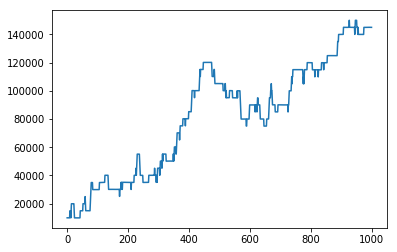

In [133]:
############### 코드 작성 ##############################



while(1):
    player_money = [10000]
    player_money_change = 10000
    game_number = [0]
    total_win = 0
    total_loss = 0
    total_draw = 0
    
    for i in range(1000):
        result, max_len = MonteCarlo.generate_episode(mc_es, dealer, agent, deck)
        if result[max_len-1][2] == 1:
            if(deck.counting > 13 ):
                player_money_change += 5000
            else:
                player_money_change += 10
            player_money.append(player_money_change)
            total_win += 1
        elif result[max_len-1][2] == -1:
            if(deck.counting > 13):
                player_money_change -= 5000
            else:
                player_money_change -= 10
            player_money.append(player_money_change)
            total_loss +=1
        else:
            player_money.append(player_money_change)
            total_draw +=1
        game_number.append(i)
        
   # plt.plot(game_number, player_money)
    print("win rate :{:.3f}%".format(total_win / (total_win + total_loss) * 100))
    if((total_win / (total_win + total_loss) * 100) > 50):
        plt.plot(game_number, player_money)
        break

########################################################

---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html